In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from numpy import polyval
from joblib import Parallel, delayed

import time

In [2]:
def flatten_and_mask_shots(shots, mask,):
    num_shots = shots.shape[0]
    size = shots.shape[1]*shots.shape[2]
    flat_mask = mask.reshape(size)
    flat_shots =  shots.reshape( (num_shots,size))*flat_mask
    
    return flat_shots[:,flat_mask]

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

In [3]:
#run71 is parameterized with ic as the reference curve
run = 71
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/\
flatfield_calibration/ave_int_statisitcs/run%d_ave_int.h5'%run,'r')
# f.keys()

f_mask = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/masks/run%d_masks.h5'%run,'r')
mask=f_mask['mask'].value

f_cali = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/\
flatfield_calibration/calibration_curves/run%d.tbl'%run,'r')
coefs = f_cali['poly_coefs'].value
ref_ind = f_cali['ref_shot_ind'].value

num_shots=f_cali['num_shots_per_bin'].value
flat_ave_shots = f['ave_flat_shots'].value
num_shots = f['num_shots_per_bin'].value

# thresholding
select=num_shots>10
flat_ave_shots = flat_ave_shots[select]
flat_std_shots = f['ave_flat_shots_err'].value[select]

ave_bin_int = f_cali['ave_bin_int'].value
print flat_ave_shots.shape,ave_bin_int.shape,coefs.shape

(22, 2223908) (22,) (2223908, 11)


In [16]:
ref_shot = flat_ave_shots[ref_ind]
ref_int = ref_shot.mean()
intensity_x = np.array([[(int-ref_int)**ii for ii in range(coefs.shape[-1])[::-1]] for int in ave_bin_int])
cali_curves = np.array([coefs.dot(xx[:,None])[:,0] for xx in intensity_x])

(17, 21)

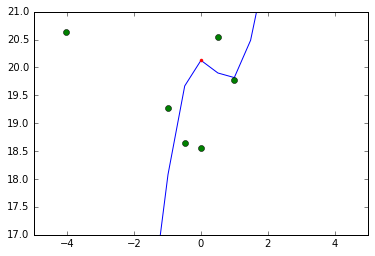

In [28]:
plt.plot(ave_bin_int-ref_int,cali_curves[:,0])
plt.plot(ave_bin_int-ref_int,flat_ave_shots[:,0],'o')
plt.plot(0,cali_curves[ref_ind,0],'.')
plt.xlim(-5,5)
plt.ylim(17,21)

In [25]:
cali_curves[ref_ind,0], flat_ave_shots[ref_ind,0]

(20.126400596539611, 18.563108444213867)

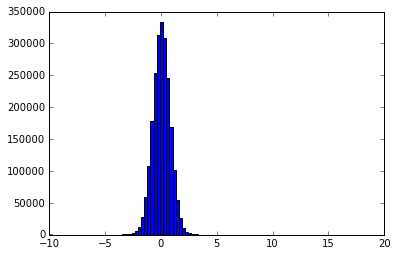

In [39]:
_=plt.hist(flat_ave_shots[0],bins=np.linspace(-10,18,100))